# Finding Atoms in STEM Data on Graphene with Deep Neural Network

**Notebook prepared by Maxim Ziatdinov**

Contact e-mail: ziatdinovmax@gmail.com

This notebook shows an example of how a fully convolutional neural network trained to "locate" atoms in noisy simulated scanning transmission electron microscopy (STEM) data can be successfully applied to real (noisy) experimental data with different resolution (e.g. 256x256 and 512x512) and shape (non-square images). The training set used for training of this particualr model was made using the atomic coordinates from molecular dynamic simulations of graphene grain boundaries and topological defects (Colin Ophus and Ashivni Shekhawat in Phys. Rev. B 92, 205402  and github.com/ashivni/Graphene)

Here "finding atoms" means obtaining a well-defined map of circular blobs on a uniform background in the output of our model. If a network is properly trained then the center of each blob in the predicted image should correspond to atomic (x, y) position. Notice that we treat al the atoms as one class (i.e. it doesn't distinguish between single impurity atoms and host lattice). This model can in principle work with images of any resolution, as long as the input image can divided by $2^{n}$ where *n* is a number of maxpooling layers in the network (3 in our case). However, there is always some optimal pixel-to-picometer ratio at which a network will work the best. I think in general it is always a good idea to determine such a ratio and (if possible) make adjustmentes to the resolution of experimental images. To give a simple example, the current network seems to work well in a range between 1 px = 8 pm and 1 px =  12 pm, which corresponds to e.g. 256x256 image over 2 nm$^2$ area or 512x512 image over 6 nm$^2$ area, rerespectively. However, If you apply this network to a 1024x1024 image over 2 nm$^2$ (or less) area, it may not work properly. In such as case, you may want to downsize your image.

There are four sets of examples in this notebook. The first one deals with regular square images of different resolution and different number of atoms. The second example shows how network performs when the image is cropped to random rectangular shapes. The third one illustrates the importance of contrast adjustments (e.g. histogram equalization) for a certain type of experimental images. Finally, the forth example show that by recognizing "physics" of the atomic structures used for training, the model developed a certain bias with respect to maximum possible number of atom connections in the graphene lattice (that is, three), which has both positive and negative implications.

Import modules:

In [1]:
import glob
import dcnn
from atomfind import *
from utils import open_hdf
import matplotlib.pyplot as plt

%matplotlib inline

Load a trained pytorch model:

In [2]:
foldername = './saved_models/'
filename = 'G-test-4-1-best_weights.pt'

model = dcnn.atomsegnet()
model = dcnn.load_torchmodel(foldername+filename, model)

## Example with images of different size (nuber of atoms) and pixel resolution

Get a list of files with image data to test:

In [3]:
foldername = './exp_data/'
filename = '*.hdf5'
filelist = glob.glob(foldername+filename)

We are now going to apply the loaded model to the test images.

Specifically, We will now make a pixel-wise prediction of where atoms are for each of the three different input images.$^1$ Notice that here we analyzed image with resolution of 512x512 and 1024x1024 even though our network was originally trained only using 256x256 images. That's the beauty of fully convolutional neural network (i.e. network without full-connected, dense layers) - it is not sensitive to the size of input image$^2$.

$^1$ The images of Si in graphene was collected by Ondrej Dyck at Oak Ridge National Lab. The images of graphene grain boudnaries were collected by Wu Zhou and Juan Carlos Idrobo at Oak Ridge National Lab.

$^2$as long as it can divided by $2^{n}$ where *n* is a number of maxpooling layers in your network

Loaded 1 image of the size 512 by 512
Sample name: Graphene
Type of experiment: HAADF
Test image name: G-GrainBoundary-4nm
1 image was decoded in approximately 1.75 seconds


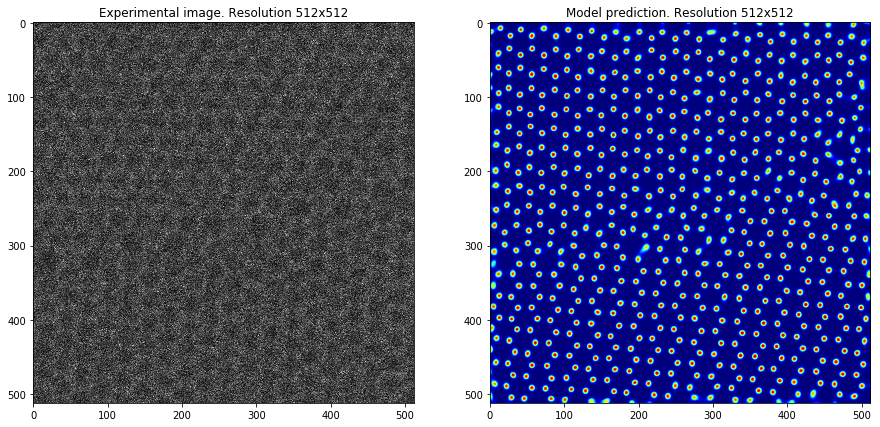

Loaded 1 image of the size 512 by 512
Sample name: Graphene
Type of experiment: HAADF
Test image name: G-GrainBoundary-6nm
1 image was decoded in approximately 1.59 seconds


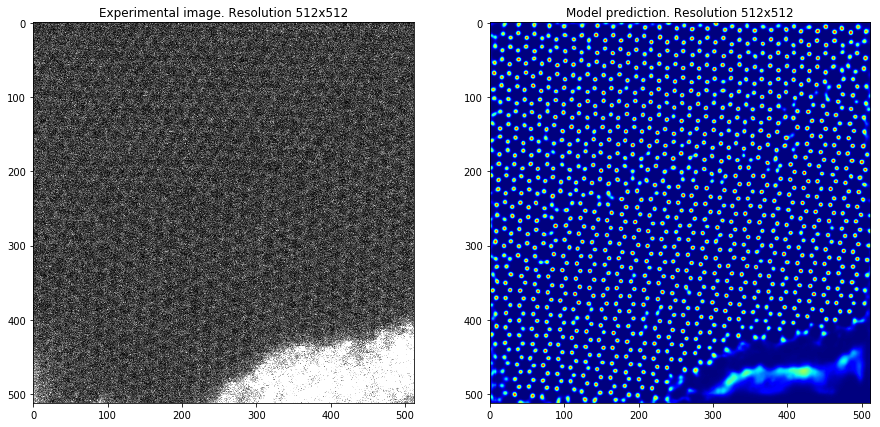

Loaded 1 image of the size 256 by 256
Sample name: Graphene
Type of experiment: HAADF
Test image name: G-Si-2nm
1 image was decoded in approximately 0.43 seconds


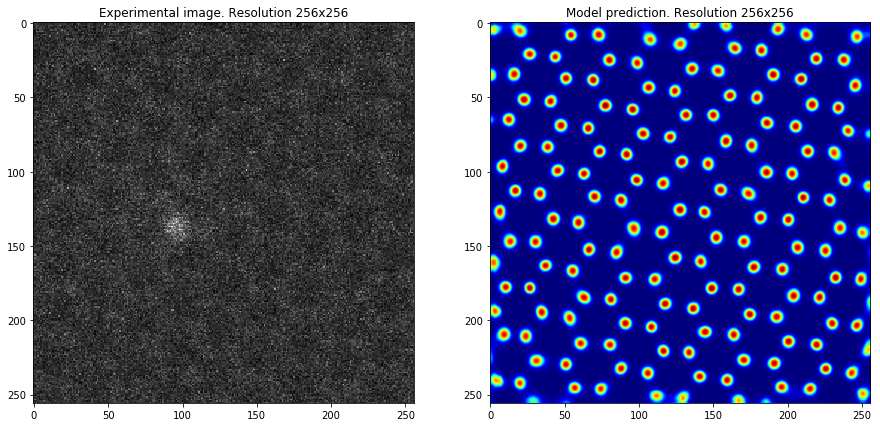

Loaded 1 image of the size 1024 by 1024
Sample name: Graphene
Type of experiment: HAADF
Test image name: G-Si-8nm-holes
1 image was decoded in approximately 8.44 seconds


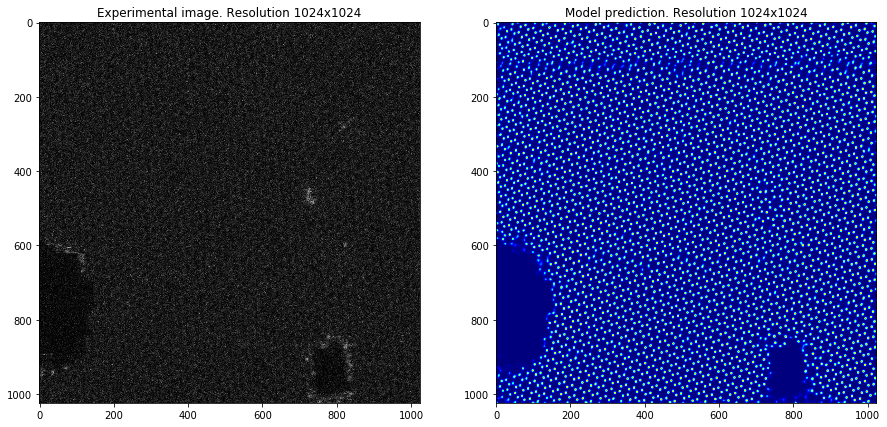

In [4]:
for f in sorted(filelist):
    k = f.split('/')[-1].split('.')[0]
    # Load experimental data as 2-d numpy array
    imgdata, _ = open_hdf(f)
    print('Test image name:', k)
    # Make a prediction using a loaded DL model
    img, dec = dl_image(imgdata, model).decode()
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
    ax1.imshow(img[0, :, :, 0], cmap = 'gray')
    ax1.set_title('Experimental image. Resolution ' + str(img.shape[1]) + 'x' + str(img.shape[2]))
    ax2.imshow(dec[0, :,:,0], cmap = 'jet', Interpolation = 'Gaussian')
    ax2.set_title('Model prediction. Resolution ' + str(dec.shape[1]) + 'x' + str(dec.shape[2]))
    plt.show()

## Example with non-square images

Now let's see how well our trained model performs on non-rectangular images. For this, we are going to do random cropping for one of the test images.

In [5]:
imgdata, _ = open_hdf(filelist[1])

Loaded 1 image of the size 512 by 512
Sample name: Graphene
Type of experiment: HAADF


1 image was decoded in approximately 0.59 seconds
Atomic/defect coordinates extracted


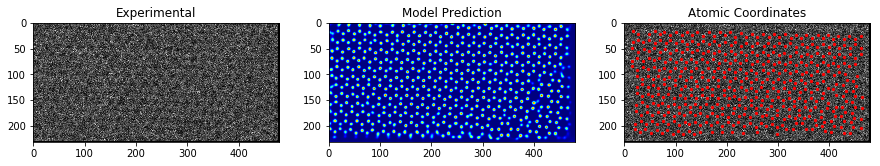

1 image was decoded in approximately 0.56 seconds
Atomic/defect coordinates extracted


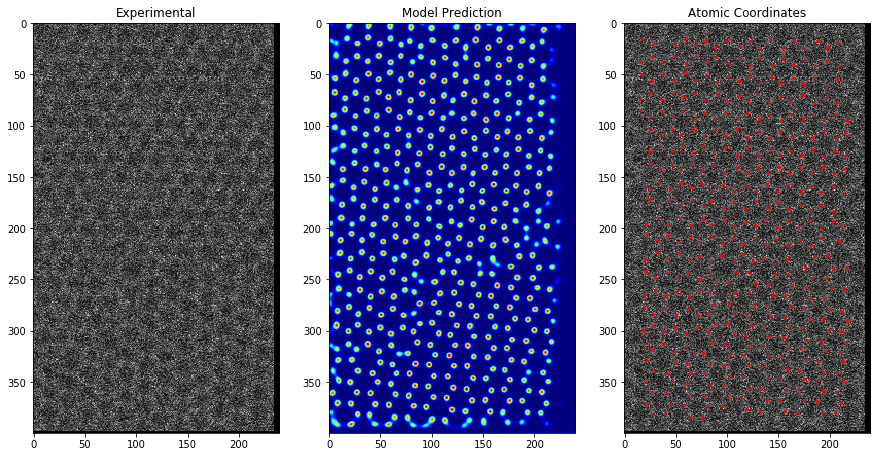

1 image was decoded in approximately 0.47 seconds
Atomic/defect coordinates extracted


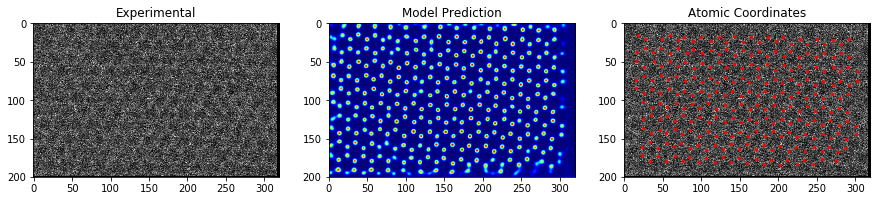

1 image was decoded in approximately 0.21 seconds
Atomic/defect coordinates extracted


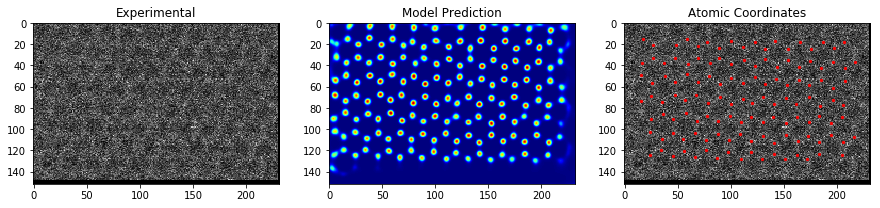

1 image was decoded in approximately 0.58 seconds
Atomic/defect coordinates extracted


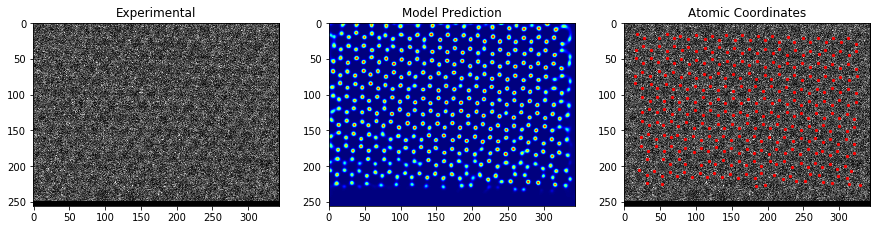

In [6]:
np.random.seed(seed = 42)
for i in range(5):
    # Randomly crop image
    x_cr = np.random.randint(imgdata.shape[0]//4, imgdata.shape[0])
    y_cr = np.random.randint(imgdata.shape[1]//4, imgdata.shape[0])
    imgdata_cr = imgdata[0:x_cr, 0:y_cr]
    # Make a prediction using a loaded DL model
    imgdata_cr_, decoded_cr = dl_image(imgdata_cr, model).decode()
    # Exract atomic coordinates from the output of DL-processed image
    coord = find_atoms(decoded_cr).get_all_coordinates(dist_edge = 15)
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))
    ax1.imshow(imgdata_cr_[0,:,:,0], cmap = 'gray')
    ax2.imshow(decoded_cr[0,:,:,0], cmap = 'jet', Interpolation = 'Gaussian')
    ax3.imshow(imgdata_cr_[0,:,:,0], cmap = 'gray')
    ax3.scatter(coord[0][:,1], coord[0][:,0], s = 5, c = 'red')
    ax1.set_title('Experimental')
    ax2.set_title('Model Prediction')
    ax3.set_title('Atomic Coordinates') 
    plt.show()   

### Examples with equalized and non-equalized histograms

The model can perform poorly on the images with large "bright" contaminations without the appropriate adjustements of image contrast (e.g. histogram equalization), as shown in the example below.

Load data:

In [8]:
foldername = './exp_data/contrast_test/'
filename = 'G-SurfaceContaminations.hdf5'
img_data,_ = open_hdf(foldername+filename)

Loaded 1 image of the size 1024 by 1024
Sample name: Graphene
Type of experiment: HAADF


Decode with and without histgram equalization:

In [9]:
_, dec1 = dl_image(img_data, model, histogram_equalization = False).decode()
_, dec2 = dl_image(img_data, model, histogram_equalization = True).decode()

1 image was decoded in approximately 6.27 seconds
1 image was decoded in approximately 6.43 seconds


Plot the results:

Text(0.5, 1.0, 'Model prediction with histogram equalization')

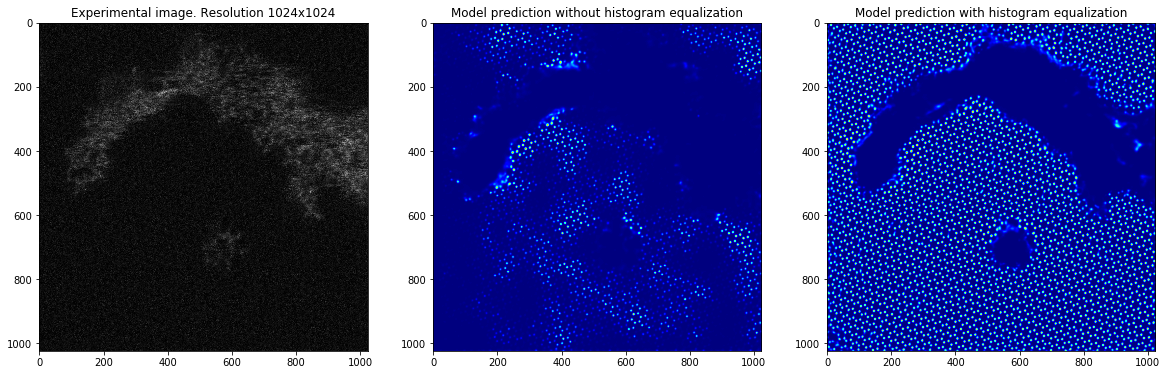

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 12))
ax1.imshow(img_data, cmap = 'gray')
ax1.set_title('Experimental image. Resolution ' + str(img_data.shape[0]) + 'x' + str(img_data.shape[1]))
ax2.imshow(dec1[0, :,:,0], cmap = 'jet', Interpolation = 'Gaussian')
ax2.set_title('Model prediction without histogram equalization')
ax3.imshow(dec2[0, :,:,0], cmap = 'jet', Interpolation = 'Gaussian')
ax3.set_title('Model prediction with histogram equalization')

## Example with resized images

There is always some optimal pixel-to-picometer ratio at which a network will work the best. In general it is always a good idea to determine such a ratio and (if possible) make adjustmentes to the resolution of experimental images. This is illustrated in the example below:

Load experimental data:

In [11]:
foldername = './exp_data/resize_test/'
filename = 'G-Si-holes.hdf5'
img_data,_ = open_hdf(foldername+filename)

Loaded 1 image of the size 1024 by 1024
Sample name: Graphene
Type of experiment: HAADF


Get the neural network output for the orginal and resized data:

In [12]:
img1, dec1 = dl_image(img_data, model).decode()
img2, dec2 = dl_image(img_data, model, (512, 512)).decode()

1 image was decoded in approximately 6.08 seconds
1 image was decoded in approximately 1.95 seconds


Get atomic coordinates:

In [13]:
coord1 = find_atoms(dec1, threshold = 0.75).get_all_coordinates(dist_edge = 15)
coord2 = find_atoms(dec2, threshold = 0.75).get_all_coordinates(dist_edge = 15)

Atomic/defect coordinates extracted
Atomic/defect coordinates extracted


Plot the results:

Text(0.5, 1.0, 'Atomic coordinates (after image resizing)')

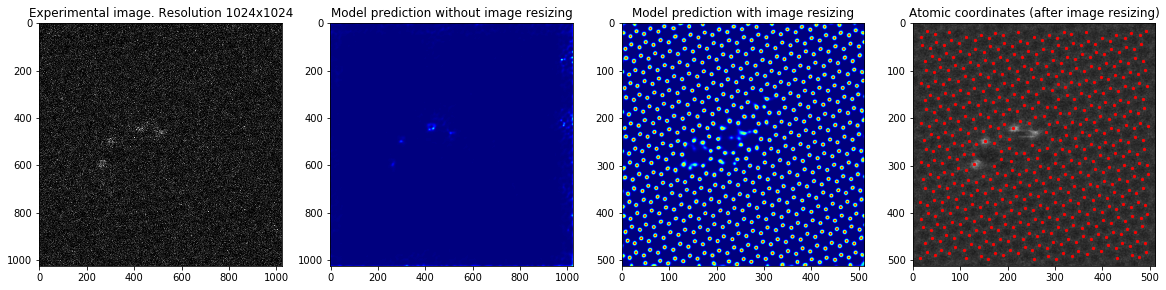

In [14]:
y, x = coord2[0][:,0:2].T
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 12))
ax1.imshow(img_data, cmap = 'gray')
ax1.set_title('Experimental image. Resolution ' + str(img_data.shape[0]) + 'x' + str(img_data.shape[1]))
ax2.imshow(dec1[0, :,:,0], cmap = 'jet', Interpolation = 'Gaussian')
ax2.set_title('Model prediction without image resizing')
ax3.imshow(dec2[0, :,:,0], cmap = 'jet', Interpolation = 'Gaussian')
ax3.set_title('Model prediction with image resizing')
ax4.imshow(img2[0,:,:,0], cmap = 'gray', Interpolation = 'Gaussian')
ax4.scatter(x, y, s = 5, c = 'red')
ax4.set_title('Atomic coordinates (after image resizing)')

As one can see, in this case it was necessary to resize the image to get proper results.

## Example of network "bias" with respect to the number of atomic connections:

Because our network was trained using the coordinates from molecular dynamics simulations of graphene grain boundaries and topological defects, it has apparently learned that atoms in graphene have three "connections" (bonds), which is kinda correct. But this also means that it gets confused in the situations where we have a dopant with a 4-fold symmetry, as shown in the example below. This can be easily addressed by adding examples with a 4-fold dopants into the training set and then retraining a neural net.

Load experimental data:

In [16]:
foldername = './exp_data/bias_test/'
filename = 'G-Si-4fold.hdf5'
img_data,_ = open_hdf(foldername+filename)

Loaded 1 image of the size 512 by 512
Sample name: Graphene
Type of experiment: HAADF


Get the neural network's output:

In [17]:
img, dec = dl_image(img_data, model, (256, 256)).decode()

1 image was decoded in approximately 0.38 seconds


Get the coordinates:

In [18]:
coord = find_atoms(dec, threshold = 0.5).get_all_coordinates(dist_edge = 15)

Atomic/defect coordinates extracted


Plot the results:

Text(0.5, 1.0, 'Atomic coordinates')

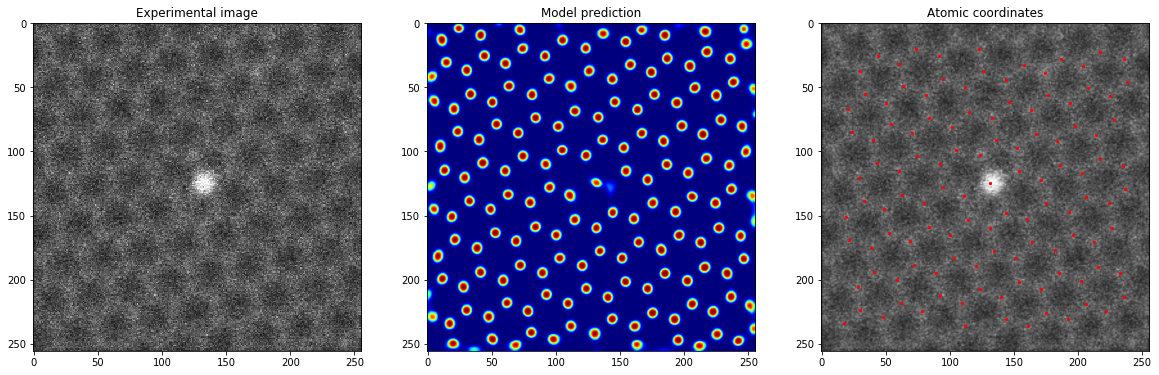

In [19]:
y, x = coord[0][:,0:2].T
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 12))
ax1.imshow(img[0,:,:,0], cmap = 'gray')
ax1.set_title('Experimental image')
ax2.imshow(dec[0,:,:,0], cmap = 'jet', Interpolation = 'Gaussian')
ax2.set_title('Model prediction')
ax3.imshow(img[0,:,:,0], cmap = 'gray', Interpolation = 'Gaussian')
ax3.scatter(x, y, s = 5, c = 'red')
ax3.set_title('Atomic coordinates')

As one can see, our model tries to put another atom next to Si with 4-fold coordination, which also results in less accurate determination of the position of Si atom. Noteice that this effect may be more profound for noisier data.